In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Ensure that Matplotlib plots display inline in Jupyter Notebooks
%matplotlib inline

In [2]:
# Paths to the dataset and TFLite model
CSV_FILE = "traffic_data.csv"
TFLITE_MODEL_PATH = "traffic_lstm_model.tflite"

# Load the traffic data from CSV file
data = pd.read_csv(CSV_FILE)

# Split the data into train and test sets (use remaining 20% for testing)
train_size = int(0.8 * len(data))
df_test = data[train_size:]  # Test data (last 20% of the dataset)

# Display the first few rows of the test data
df_test.head()

,DateTime,Junction,Vehicles,ID
38496,2016-11-23 00:00:00,3,17,20161123003
38497,2016-11-23 01:00:00,3,12,20161123013
38498,2016-11-23 02:00:00,3,10,20161123023
38499,2016-11-23 03:00:00,3,7,20161123033
38500,2016-11-23 04:00:00,3,4,20161123043


In [3]:
# Instantiate the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Split the data into train and test sets (use remaining 20% for testing)
df_test = data[train_size:].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Debug: Check if df_test is empty
if df_test.empty:
    raise ValueError("df_test is empty. Check the train_size calculation or input data.")

# Debug: Check for NaN values in the 'Vehicles' column
if df_test['Vehicles'].isna().sum() > 0:
    raise ValueError("NaN values found in the 'Vehicles' column. Please clean the input data.")

# Normalize the 'Vehicles' column using MinMaxScaler
df_test.loc[:, 'Vehicles_Normalized'] = scaler.fit_transform(df_test[['Vehicles']])

# Generate lag and rolling mean features
df_test.loc[:, 'Lag_1'] = df_test['Vehicles_Normalized'].shift(1)
df_test.loc[:, 'Lag_2'] = df_test['Vehicles_Normalized'].shift(2)
df_test.loc[:, 'Lag_3'] = df_test['Vehicles_Normalized'].shift(3)
df_test.loc[:, 'Rolling_Mean_3'] = df_test['Vehicles_Normalized'].rolling(window=3).mean()

# Drop rows with NaN values caused by lag/rolling features
df_test.dropna(inplace=True)

# Display the data with new features
df_test.head()

,DateTime,Junction,Vehicles,ID,Vehicles_Normalized,Lag_1,Lag_2,Lag_3,Rolling_Mean_3
38499,2016-11-23 03:00:00,3,7,20161123033,0.033520,0.050279,0.061453,0.089385,0.048417
38500,2016-11-23 04:00:00,3,4,20161123043,0.016760,0.033520,0.050279,0.061453,0.033520
38501,2016-11-23 05:00:00,3,7,20161123053,0.033520,0.016760,0.033520,0.050279,0.027933
38502,2016-11-23 06:00:00,3,10,20161123063,0.050279,0.033520,0.016760,0.033520,0.033520
38503,2016-11-23 07:00:00,3,9,20161123073,0.044693,0.050279,0.033520,0.016760,0.042831


In [4]:
# Prepare input features (X) and target values (y_actual)
X = df_test[['Lag_1', 'Lag_2', 'Lag_3', 'Rolling_Mean_3']].values
y_actual = df_test['Vehicles_Normalized'].values

In [5]:
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [6]:
# Predict traffic volume using a sliding window approach
predictions = []
for i in range(len(X) - 2):
    input_data = X[i:i + 3]  # Use 3 consecutive rows as input
    input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension
    interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])[0][0]
    predictions.append(prediction)

# Ensure y_actual has the same length as predictions
y_actual = y_actual[2:]

In [7]:
# Reverse normalization to compare with actual values
y_actual = scaler.inverse_transform(y_actual.reshape(-1, 1))
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [8]:
# Calculate performance metrics
mse = mean_squared_error(y_actual, predictions)
mae = mean_absolute_error(y_actual, predictions)
mape = mean_absolute_percentage_error(y_actual, predictions)
accuracy = 100 - mape * 100  # Percentage accuracy

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Model Accuracy: {accuracy:.2f}%")

Mean Squared Error (MSE): 6.5455
Mean Absolute Error (MAE): 1.5171
Mean Absolute Percentage Error (MAPE): 0.2116
Model Accuracy: 78.84%


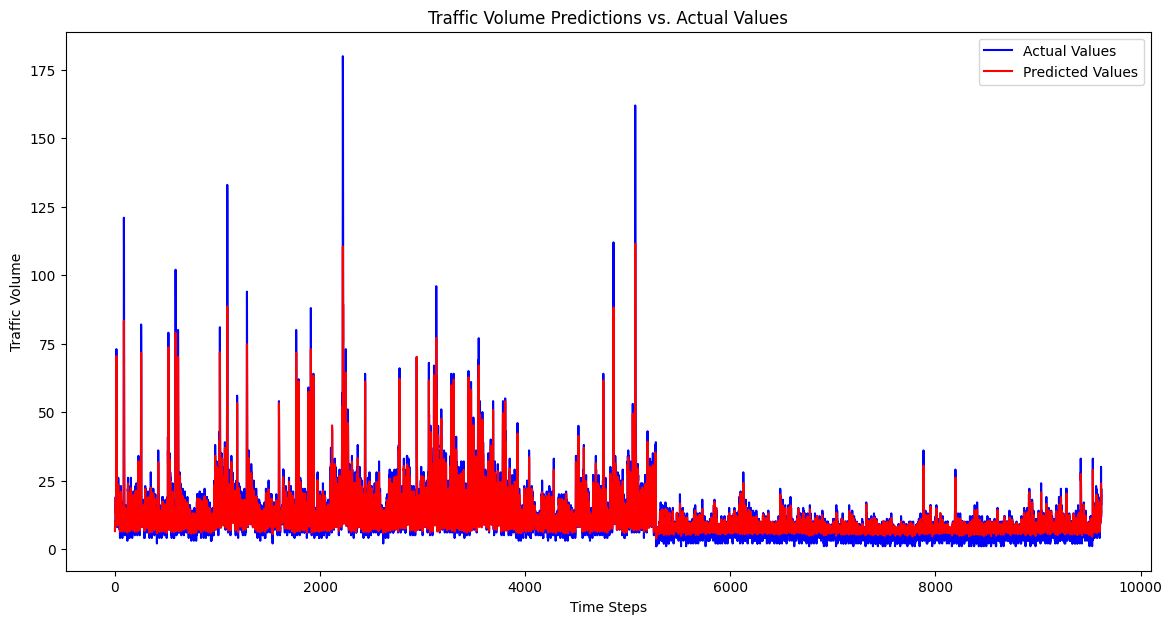

In [9]:
# Plot Predictions vs. Actual Values
plt.figure(figsize=(14, 7))
plt.plot(y_actual, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red')
plt.legend()
plt.title('Traffic Volume Predictions vs. Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Traffic Volume')
plt.show()

In [10]:
# Save metrics to a text file
with open("evaluation_metrics.txt", "w") as f:
    f.write(f"Mean Squared Error (MSE): {mse:.4f}\n")
    f.write(f"Mean Absolute Error (MAE): {mae:.4f}\n")
    f.write(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}\n")
    f.write(f"Model Accuracy: {accuracy:.2f}%\n")

# Save predictions and actual values for later analysis
results_df = pd.DataFrame({
    'Actual': y_actual.flatten(),
    'Predicted': predictions.flatten()
})
results_df.to_csv("predictions_vs_actuals.csv", index=False)
print("Metrics and results saved successfully.")


Metrics and results saved successfully.
